# Value at Risk (VaR) Calculation in Python with Visualizations

This notebook demonstrates the calculation of Value at Risk (VaR) using three common methods:
 1.  **Historical Simulation**
 2.  **Variance-Covariance (Parametric)**
 3.  **Monte Carlo Simulation**

In [1]:
import numpy as np #for numerical computation
import pandas as pd #for data manipulation
import seaborn as sns #asthetic plots
import matplotlib as mpl #for plotting
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'

import yfinance as yf #for downloading historical market data from Yahoo Finance

# Setup and Data Import
## Defining a portfolio of assets

Here we are setting up the portfolio by defining a list of stock tickers, and then we'll use `yfinance` to retrieve the historical adjusted closing prices for these stocks over a specified period.  The start and end dates determine the timeframe for the data.

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN'] # Example stock tickers
start_date = '2023-01-01'
end_date = '2024-01-01'
# downloading data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)['Close']
# display the data
print("\n")
print(data.head())

[*********************100%***********************]  4 of 4 completed




Ticker            AAPL       AMZN       GOOG        MSFT
Date                                                    
2023-01-03  123.632530  85.820000  89.378853  235.711731
2023-01-04  124.907707  85.139999  88.392395  225.400925
2023-01-05  123.583099  83.120003  86.459335  218.720551
2023-01-06  128.130219  86.080002  87.844376  221.298248
2023-01-09  128.654129  87.360001  88.482086  223.452896


## Calculate Daily Returns
Next, calculate the daily percentage returns of each stock in our portfolio. This is a crucial step as VaR is typically calculated based on return distributions.

In [3]:
#calculating the daily return
returns = data.pct_change().dropna()
print(returns.head())

Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2023-01-04  0.010314 -0.007924 -0.011037 -0.043743
2023-01-05 -0.010605 -0.023726 -0.021869 -0.029638
2023-01-06  0.036794  0.035611  0.016020  0.011785
2023-01-09  0.004089  0.014870  0.007260  0.009736
2023-01-10  0.004457  0.028732  0.004955  0.007617


## Portfolio Weights
Define the weights for each asset in the portfolio. For simplicity, let's assume an equally weighted portfolio.

$$w = \frac{1}{N}$$
where $N$ is the number of assets in the portfolio.


In [4]:
weights = np.array([1/len(tickers)] * len(tickers))
print(weights)

[0.25 0.25 0.25 0.25]


## Portfolio Returns
Calculate the portfolio's daily returns by multiplying the individual asset returns with their respective weights and summing them up.
$$r_P = \sum_{i=0}^{N} r_i\cdot w_i$$

In [5]:
portfolio_returns = returns @ weights
print(portfolio_returns.head())

Date
2023-01-04   -0.013097
2023-01-05   -0.021459
2023-01-06    0.025053
2023-01-09    0.008989
2023-01-10    0.011440
dtype: float64


# Historical Simulation VaR

The Historical Simulation method involves using historical returns to simulate potential future portfolio losses.

## Calculate Historical Simulation VaR


In [6]:
def historical_var(returns:pd.Series, confidence_level:float=0.95)->float:
    """
    Calculates Value at Risk (VaR) using the historical simulation method.

    Args:
        returns (pd.Series): A pandas Series of portfolio returns.
        confidence_level (float): The confidence level for VaR (e.g., 0.95 for 95% confidence).

    Returns:
        float: The VaR value.
    """
    # Calculate the VaR as the percentile of the returns distribution
    var = np.percentile(returns, (1 - confidence_level) * 100)
    return var

# Calculate the 95% historical VaR
var_historical = historical_var(portfolio_returns, confidence_level=0.95)
print(f"Historical VaR at 95% confidence level: {var_historical:.4f}")

Historical VaR at 95% confidence level: -0.0215


### Visualize Historical VaR

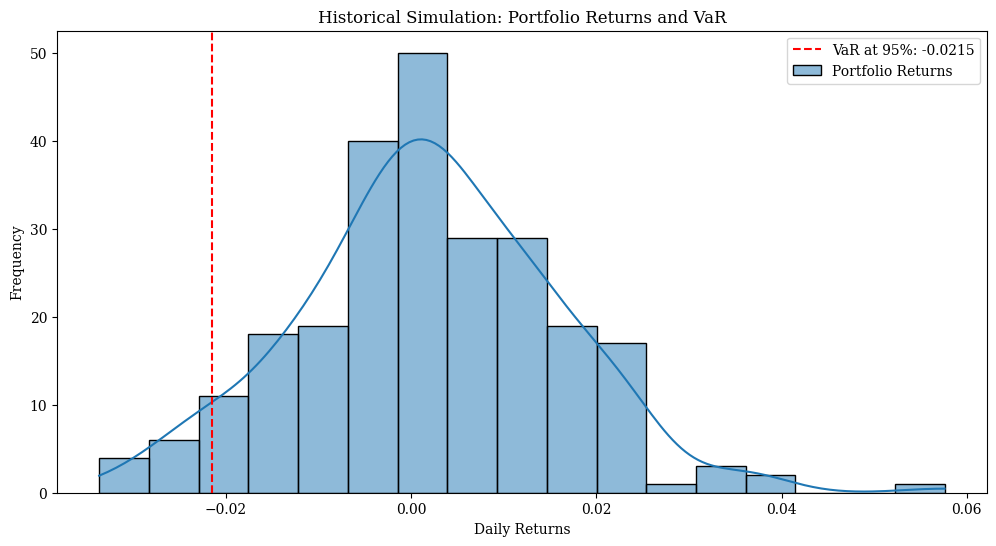

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(portfolio_returns, kde=True, label='Portfolio Returns')
plt.axvline(var_historical, color='red', linestyle='--', label=f'VaR at 95%: {var_historical:.4f}')
plt.title('Historical Simulation: Portfolio Returns and VaR')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Interpretation of Historical VaR at 95% Confidence Level
A Historical VaR of -0.0215 at 95% confidence means that, based on past market data, there is a 95% probability that **the portfolio will not lose more than 2.15% of its value daily**. Conversely, there is a 5% probability that the loss will exceed 2.15% in a day.

# Variance-Covariance (Parametric) VaR
The Variance-Covariance method assumes that the portfolio returns are normally distributed and calculates VaR based on the mean and standard deviation of the returns.

## Calculate Mean and Standard Deviation
Calculate the mean and standard deviation of the portfolio returns.

In [8]:
mean_return = portfolio_returns.mean()
std_dev = portfolio_returns.std()
print(f"Mean Return: {mean_return:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")

Mean Return: 0.0021
Standard Deviation: 0.0139


## Calculate Parametric VaR

In [9]:
from scipy.stats import norm #for PDF and CDF of normal distribution

def parametric_var(mean:float, std:float, confidence_level:float=0.95)->float:
    """
    Calculates Value at Risk (VaR) using the parametric (variance-covariance) method,
    assuming a normal distribution of returns.

    Args:
        mean (float): The mean of the portfolio returns.
        std (float): The standard deviation of the portfolio returns.
        confidence_level (float): The confidence level for VaR (e.g., 0.95 for 95% confidence).

    Returns:
        float: The VaR value.
    """
    # Calculate the z-score for the given confidence level
    z_score = norm.ppf(1 - (1 - confidence_level))

    # Calculate the VaR
    var = mean - z_score * std
    return var

# Calculate the 95% parametric VaR
var_parametric = parametric_var(mean_return, std_dev, confidence_level=0.95)
print(f"Parametric VaR at 95% confidence level: {var_parametric:.4f}")

Parametric VaR at 95% confidence level: -0.0208


### Visualize Parametric VaR

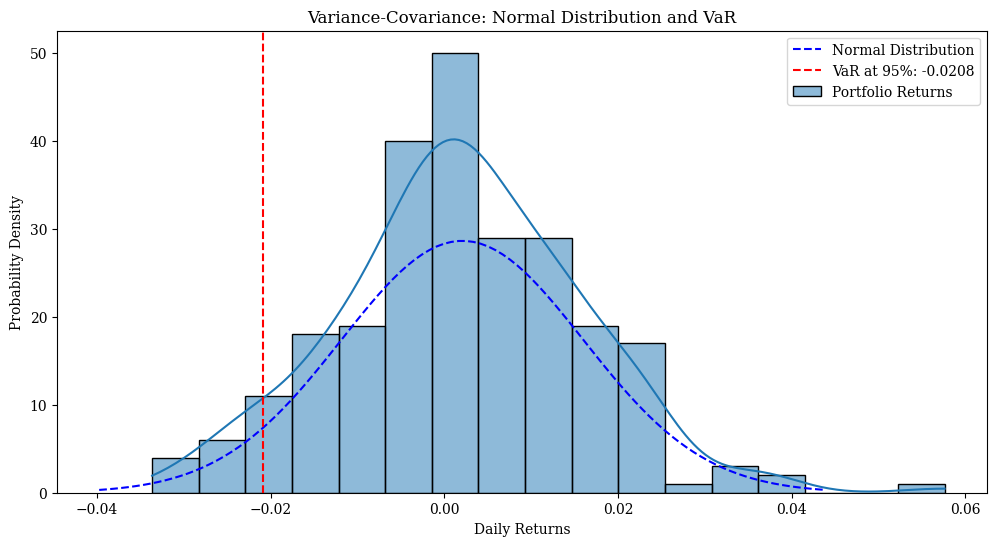

In [10]:
x = np.linspace(mean_return - 3*std_dev, mean_return + 3*std_dev, 100)
plt.figure(figsize=(12, 6))
sns.histplot(portfolio_returns, kde=True, label='Portfolio Returns')
plt.plot(x, norm.pdf(x, mean_return, std_dev), label='Normal Distribution', color='blue', ls='--')
plt.axvline(var_parametric, color='red', linestyle='--', label=f'VaR at 95%: {var_parametric:.4f}')
plt.title('Variance-Covariance: Normal Distribution and VaR')
plt.xlabel('Daily Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### Interpretation of Parametric VaR at 95% Confidence Level
A Historical VaR of -0.0208 at 95% confidence means that, based on past market data, there is a 95% probability that **the portfolio will not lose more than 2.08% of its value daily**. Conversely, there is a 5% probability that the loss will exceed 2.08% in a day.

# Monte Carlo Simulation VaR

The Monte Carlo Simulation method involves generating a large number of random price paths for the assets in the portfolio, based on certain assumptions about their statistical properties. This is a more complex method but can provide a more accurate VaR estimate, especially for portfolios with non-linear assets.

## Simulation Parameters
Define the simulation parameters such as the number of simulations and the time horizon.

In [11]:
n_simulations = 10000
time_horizon = 1  # 1 day

## Generate Random Price Paths
Generate random price paths for the assets in the portfolio, assuming a normal distribution of returns.

In [12]:
def monte_carlo_var(returns:pd.Series, weights:np.array, n_simulations:int=10000,
                    time_horizon:int=1, confidence_level:float=0.95)->(float, np.array):
    """
    Calculates Value at Risk (VaR) using the Monte Carlo simulation method,
    assuming a normal distribution of returns.

    Args:
        returns (pd.DataFrame): A pandas DataFrame of daily returns for each asset.
        weights (np.array): A numpy array of portfolio weights for each asset.
        n_simulations (int): The number of simulations to run.
        time_horizon (int): The time horizon for VaR (in days).
        confidence_level (float): The confidence level for VaR (e.g., 0.95 for 95% confidence).

    Returns:
        float: The VaR value.
    """
    # Calculate the mean and standard deviation of the daily returns
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Generate random price paths
    rand_matrix = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_simulations)

    # Calculate the portfolio returns for each simulation
    portfolio_returns = rand_matrix @ weights * time_horizon

    # Calculate the VaR as the percentile of the returns distribution
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var, rand_matrix

# Calculate the 95% Monte Carlo VaR
var_monte_carlo, rand_matrix = monte_carlo_var(returns, weights, n_simulations=10000, time_horizon=1, confidence_level=0.95)
print(f"Monte Carlo VaR at 95% confidence level: {var_monte_carlo:.4f}")

Monte Carlo VaR at 95% confidence level: -0.0207


### Visualize Monte Carlo Simulation VaR

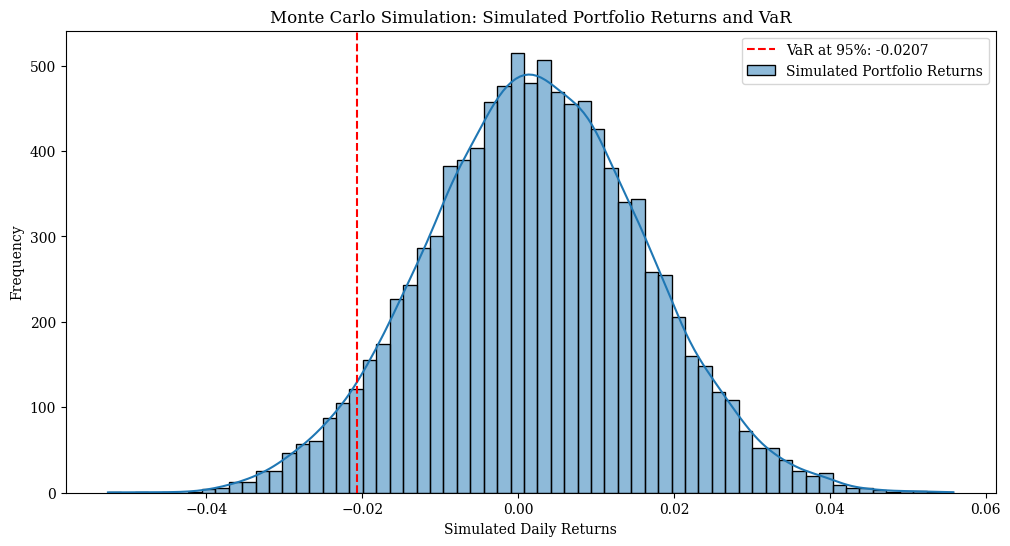

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(rand_matrix @ weights, kde=True, label='Simulated Portfolio Returns')
plt.axvline(var_monte_carlo, color='red', linestyle='--', label=f'VaR at 95%: {var_monte_carlo:.4f}')
plt.title('Monte Carlo Simulation: Simulated Portfolio Returns and VaR')
plt.xlabel('Simulated Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Summary

-   VaR provides a single number summarizing potential losses.
-   Different methods have different assumptions and limitations.
-   Historical Simulation is non-parametric but relies on historical data.
-   Variance-Covariance is fast but assumes normality.
-   Monte Carlo Simulation is flexible but computationally intensive.
-   VaR should be complemented with stress testing.

## **Note on Backtesting Procedure for VaR Validation:**

Backtesting is a critical step in validating the accuracy of any VaR model.  It involves comparing the predicted VaR to the actual observed portfolio returns over a historical period. Here's a general procedure:

1.  **Calculate VaR for each day:** Use one of the VaR methods (Historical Simulation, Variance-Covariance, or Monte Carlo) to calculate the VaR for each day in your backtesting period.  This calculation is based on data *up to* that day.
2.  **Identify Exceedances:**  For each day, compare the actual portfolio return to the negative of the calculated VaR (since VaR represents a loss).  An "exceedance" occurs when the actual loss (negative return) is *greater* than the VaR.  In other words, `actual_return < -VaR`.
3.  **Calculate the Exceedance Ratio:** The exceedance ratio is the number of exceedances divided by the total number of days in the backtesting period.
4.  **Compare to Expected Exceedances:**  The expected exceedance ratio is `1 - confidence_level`.  For example, if your VaR is calculated at a 95% confidence level, you would expect an exceedance ratio of approximately 5%.
5.  **Assess Model Accuracy:**
    *   If the exceedance ratio is significantly higher than expected, it suggests that the VaR model is underestimating risk.
    *   If the exceedance ratio is significantly lower than expected, it suggests that the VaR model is overestimating risk.
 6. **Statistical Tests:** More sophisticated backtesting procedures involve statistical tests (e.g., Kupiec's test) to formally assess whether the observed number of exceedances is statistically consistent with the expected number.

 **Important Considerations:**
 *   **Backtesting Period:**  The backtesting period should be long enough to provide a statistically meaningful sample of returns.
 *   **Data Independence:**  Ideally, the data used for backtesting should be independent of the data used to build the VaR model.  This can be achieved by using a separate "out-of-sample" dataset.
 *   **Model Updates:**  VaR models should be periodically updated and re-evaluated to ensure that they continue to accurately reflect the risk characteristics of the portfolio.

*This notebook provided a hands-on introduction to calculating VaR using Python. Remember that VaR is just one tool in risk management and should be used in conjunction with other techniques.*